# Multi Class Classification with CrossEntropyLoss

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
train_data = './Dataset/train/'
test_data = './Dataset/test/'

In [18]:
img_size = 224

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Grayscale(),
    transforms.Resize((img_size,img_size))])


class CustomLoader(torch.utils.data.Dataset):
    def __init__(self, data_path, transform):
        self.path = data_path
        self.files = []
        for dir_path, currentDirectory, dir_files in os.walk(data_path):
            for file in dir_files:
                self.files.append(dir_path + '/' + file)
        self.indices = len(self.files)
        self.transform = transform

    def __getitem__(self, idx):
        image = Image.open(self.files[idx]).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        label = int(self.files[idx].split('-')[0][-1:])

        return image.to(device), torch.tensor(label).long().to(device)

    def __len__(self):
        return self.indices

tensor(1, device='cuda:0')


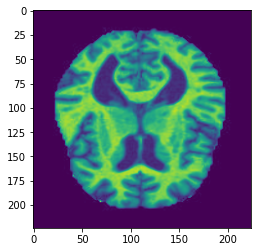

In [19]:
data = CustomLoader(train_data, transform)
im, label = data[4850]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [4]:
def conv_layer(ni,no,kernel_size,stride=1):
    return nn.Sequential(
        nn.Conv2d(ni, no, kernel_size, stride),
        nn.ReLU(),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2)
    )

def get_model():
    model = nn.Sequential(
        conv_layer(1, 64, 3),
        conv_layer(64, 512, 3),
        conv_layer(512, 512, 3),
        conv_layer(512, 512, 3),
        conv_layer(512, 512, 3),
        conv_layer(512, 512, 3),
        nn.Flatten(),
        nn.Linear(512, 4)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)

    return model, loss_fn, optimizer

from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, (1, 224, 224));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 222, 222]             640
              ReLU-2         [-1, 64, 222, 222]               0
       BatchNorm2d-3         [-1, 64, 222, 222]             128
         MaxPool2d-4         [-1, 64, 111, 111]               0
            Conv2d-5        [-1, 512, 109, 109]         295,424
              ReLU-6        [-1, 512, 109, 109]               0
       BatchNorm2d-7        [-1, 512, 109, 109]           1,024
         MaxPool2d-8          [-1, 512, 54, 54]               0
            Conv2d-9          [-1, 512, 52, 52]       2,359,808
             ReLU-10          [-1, 512, 52, 52]               0
      BatchNorm2d-11          [-1, 512, 52, 52]           1,024
        MaxPool2d-12          [-1, 512, 26, 26]               0
           Conv2d-13          [-1, 512, 24, 24]       2,359,808
             ReLU-14          [-1, 512,

In [5]:
def get_data():
    train = CustomLoader(train_data, transform)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last=True)

    test = CustomLoader(test_data, transform)
    test_dl = DataLoader(test, batch_size=32, shuffle=True, drop_last=True)

    return trn_dl, test_dl

In [6]:
def train_batch(x, y, model, optimizer, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [7]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [8]:
@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [9]:
trn_dl, test_dl = get_data()
model, loss_fn, optimizer = get_model()

In [10]:
cuda = True if torch.cuda.is_available() else False

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

num_epochs = 20

for epoch in range(num_epochs):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer,
                                 loss_fn)
        train_epoch_losses.append(batch_loss)

    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)

    for ix, batch in enumerate(iter(test_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)

0
1
2
3


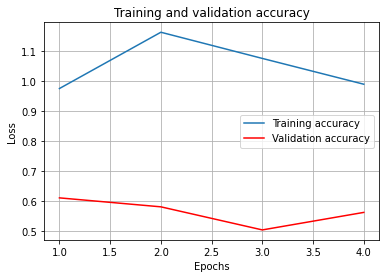

In [17]:
import matplotlib.pyplot as plt

epochs = np.arange(num_epochs)+1

plt.plot(epochs, train_losses, label='Training accuracy')
plt.plot(epochs, train_accuracies, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

tensor(2, device='cuda:0')

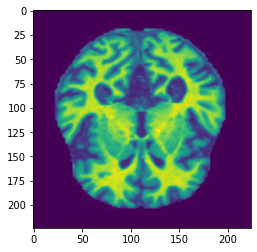

In [12]:
data = CustomLoader(train_data, transform)
im, label = data[10]
plt.imshow(im.permute(1,2,0).cpu())
label

In [13]:
test = im.unsqueeze(0)
prediction = model(test).cpu().detach().numpy()
pred = np.exp(prediction)/np.sum(np.exp(prediction))
pred

array([[0.40617895, 0.48474234, 0.10358684, 0.00549183]], dtype=float32)

In [50]:
PATH = "./model/classifier/model.pt"

torch.save({
    'classifier': model.state_dict(),
    'optimizer_D': optimizer.state_dict(),
}, PATH)